# Audio Processing Lab 5: Microphone Array Processing
Gizem Tabak

We will perform some basic microphone array processing. We have an 8-channel audio recording. Each channel is a recording from a microphone, and the microphones were positioned at 0.1 meters from each other. Using the recording, we will localize two sources and beamform to enhance the sound we hear from each one.

In [ ]:
#@title Import packages
%matplotlib inline
import scipy.signal as sgn
import scipy.io.wavfile as wv
import matplotlib.pyplot as plt
import numpy as np
import IPython
from matplotlib import mlab as mlab
from os.path import join

plt.rcParams["figure.figsize"] = (10, 6)

## Part 1: Getting the steering vectors

For each microphone $m$, direction $\theta$ and frequency bin $k$, steering vector is defined as 

$v(m, \theta, k) = e^{-j\tfrac{(m-1)r\cos (\theta)}{C}\tfrac{2\pi k}{N}R}$

The most straightforward way to compute the steering vectors is to implement 3 nested `for` loops for each parameter.

In [ ]:
fs, arr = wv.read('data/array.wav')

NDFT = 1024
n_m = np.shape(arr)[1]
n_theta = 50
n_k = NDFT//2+1
r = 0.1
C = 345
theta_vec = np.linspace(0, np.pi, n_theta)
# Steering vectors
V = np.zeros((n_m, n_theta, n_k), dtype=complex)
for m in range(n_m):
    for theta_idx in range(len(theta_vec)):
        theta = theta_vec[theta_idx]
        for k in range(n_k):
            V[m, theta_idx, k] = np.exp(-1j*(m*r*np.cos(theta)*fs*2*np.pi*k)/(C*NDFT))

A less straightforward but faster way is to construct a $8\times50\times513$ tensor by tensor multiplying 3 arrays, $M=[0, ... ,8-1], D=[\cos(0),...,\cos(\pi)]$ and $K=[0,...,512]$, and applying other operations elementwise (with `numpy` functions) on that tensor. The first array corresponds to the microphone $m$, the second array corresponds to the direction $\theta$ and the last one corresponds to the frequency bin $k$. 
The resulting arrays are equal up to numerical calculation errors.

In [ ]:
D = np.cos(theta_vec)
D.shape = (n_theta, 1)

K = np.array(range(0, n_k))
K.shape = (1, n_k)

M = np.array(range(0, n_m))
M.shape = (1, n_m)

t = np.tensordot(M, np.dot(D, K), 0)[0]
V_tensor = np.exp(-1j*(r*fs*2*np.pi*t)/(C*NDFT))

print(np.max(np.abs(V - V_tensor)))

5.685667168744362e-14


## Part 2: Localization

First, I tried listening all the channels one by one. It sounds like there are two sources: One musical source and one speech. Obviously, I could not hear any directional cue by listening to each channel individually. When I combine the outputs from two microphones, I was able to identify source locations a little bit: One of them was on the left side and the other one was on the right. But since I don't know the direction of arrangement of the microphones, it is not possible to tell which one is on which side. Also, it is not possible to tell the exact accurate direction by just listening.

In [ ]:
fs, arr = wv.read('data/array.wav')
print('Individual Channels')
for i in range(8):
    IPython.display.display( IPython.display.Audio(arr[:,i], rate=fs));
print('Stereo')
IPython.display.display( IPython.display.Audio(np.vstack((arr[:,0], arr[:,7])), rate=fs))

Individual Channels


Stereo


In [ ]:
#@title Helper function for STFT
def stft( input_sound, dft_size, hop_size, zero_pad, window):
    if len(np.shape(input_sound)) == 1:
        # Forward transform
        input_sound_padded = np.zeros(len(input_sound) + dft_size - zero_pad + hop_size - len(input_sound)%hop_size)
        input_sound_padded[:len(input_sound)] = input_sound
        L = len(input_sound_padded) -  dft_size
        stft_output = np.zeros([int((dft_size)/2) + 1, int(L/hop_size)], dtype=complex)
        for i in range(0, int(L/hop_size)):
            seg = input_sound_padded[(i*hop_size):(i*hop_size + dft_size - zero_pad)]
            # Choose and apply window if selected
            if window == 'triangular':
                seg = np.multiply(seg, np.bartlett(dft_size - zero_pad))
            elif window == 'hann':
                seg = np.multiply(seg, np.hanning(dft_size - zero_pad))
            elif window == 'hamming':
                seg = np.multiply(seg, np.hamming(dft_size - zero_pad))
            elif window == 'kaiser':
                seg = np.multiply(seg, np.kaiser(dft_size - zero_pad, beta=0.8))
            # Change size variable so that it will pad zeros to input    
            s_stft = np.fft.rfft(seg, dft_size)            
            stft_output[:,i] = s_stft
            
        # X = np.arange(0, (int(L/hop_size)*hop_size)/fs, hop_size/fs)
        # Y = np.arange(0, fs/2, fs/(2*(int((dft_size)/2) + 1)))
        # # Make zero elements equal to the smallest value to avoid log(0) for plotting
        # min_nonzero = np.min(stft_output[np.nonzero(stft_output)])
        # stft_output[stft_output == 0] = min_nonzero

        # plt.pcolormesh(X, Y, 20*np.log10(np.abs(stft_output)))
        # plt.xlabel('Time (sec)')
        # plt.ylabel('Freq (Hz)')
        # plt.title('DFT=%d HOP=%d PAD=%d WINDOW=%s' %(dft_size, hop_size, zero_pad, window))
 
        # plt.show()

        return stft_output
    elif len(np.shape(input_sound)) == 2:
        # Inverse transform
        L = (np.shape(input_sound)[1]+1)*hop_size
        stft_output = np.zeros([int(L)+hop_size,])
        for i in range(0, int((L - dft_size)/hop_size)):
            s_stft = np.fft.irfft(input_sound[:,i], dft_size)
            if len(window) > 0:
                # Window should only cover nonzero part, not zero paddings
                if window == 'triangular':
                    w = np.bartlett(dft_size - zero_pad)
                elif window == 'hann':
                    w = np.hanning(dft_size - zero_pad)
                elif window == 'hamming':
                    w = np.hamming(dft_size - zero_pad)
                elif window == 'kaiser':
                    w = np.kaiser(dft_size - zero_pad, beta=0.8)
                # Pad window with zeros to make dimensions equal
                window_padded = np.concatenate([w, np.zeros([zero_pad,])])
                s_stft = np.multiply(s_stft, window_padded)
            # Overlap and add
            stft_output[i*hop_size:(i*hop_size + dft_size)] += s_stft
        
        return stft_output

In order to solve the localization problem, we need to find the acoustic energy coming from each direction $\theta$. Since the acousic energy decreases as the sound waves travel further from the sources, the peaks representing the high acoustic energy in the resulting plot will tell us the direction of the sources.

In order to measure the intensity at a given direction, we hypothesize as if the source is located in that given direction. First, we undo the hypothesized delays at the microphones based on their relative locations. Then, we sum the signals coming from all the channels as if the microphones are all located at equal distance from the source. If we are right with our hypothesis, meaning the source is located at that given direction, the signals will add up constructively and boost the outcome. If we are wrong, they will add up destructively, resulting in lower intensity total signal.

To calculate the signal intensity at a given direction, we use DFT since the phase delays (and how we undo them) will depend on frequency. In the below code, I calculated the intensity at a given direction $\theta$ using STFT of signals at each channel, denoted by $S[m,k, n]$, and steering vector array $V[m, \theta,k,n]=V[m, \theta,k]$ as follows:

$I = \sqrt{\dfrac{\sum_{k=0}^{K-1}\sum_{n=0}^{N-1}|\sum_m V^*[m,\theta, k,n]S[m,k,n]|^2}{KN}}$

The resulting Direction vs Intensity plot shows that there are indeed two sources, one located around 30˚ on the right side ($\theta=60˚$), the other is located around 20˚ on the left ($\theta=110˚$).

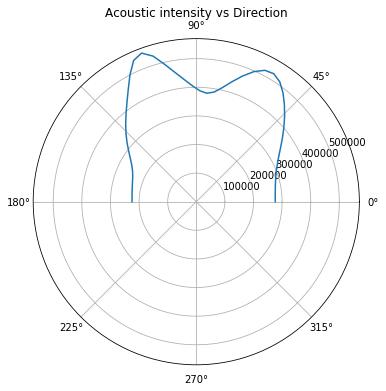

In [ ]:
hop_size = 256
zero_pad = 128
L = np.shape(arr)[0] + hop_size - zero_pad - np.shape(arr)[0]%hop_size
I = np.zeros((n_m, n_theta, n_k, int(L/hop_size)), dtype=complex)
for m in range(n_m):
    arr_stft = stft(arr[:,m], NDFT, hop_size, zero_pad, 'hann')
    for theta_idx in range(n_theta):
        theta = theta_vec[theta_idx]
        I[m, theta_idx, :, :] = np.tile(np.conjugate(V[m, theta_idx, :]).T, (int(L/hop_size),1)).T*arr_stft

I_theta = np.mean(np.mean(np.abs(np.sum(I, axis=0))**2, axis=1), axis=1)**0.5
plt.polar(theta_vec, I_theta)
plt.title('Acoustic intensity vs Direction')
plt.show()
# print(max(I_theta)/max(np.mean(np.mean(np.abs(I[0,:,:,:])**2, axis=1), axis=1)**0.5))

## Part 3: Beamforming

Looking at the above intensity plot, one of the peaks is the maximum value between 0-90˚ and the other one is the maximum between 90-180˚. Hence, I identified the peaks in each quadrant and found the corresponding $\theta$ value to use them in order to focus at those directions. The code is similar to localization, but instead of hypothesizing different directions, this time we know the directions for both of the sources. Thus, we can use those directions to undo the phase delays. After correcting the phase delays, the signals from each microphone will align nicely and boost the sound coming from that direction.

When I listen to the resulting clips, musical notes is more dominant in the first clip and the speech sounds more dominant in the second clip. This means that the musical instruments (or the music player) is our Source 1 and located at 31˚ on the right, while Source 2 is the speaker located at 20˚ on the left.


In [ ]:
idx_sort1 = np.argsort(I_theta[(theta_vec < np.pi/2)])
idx_sort2 = np.argsort(I_theta[(theta_vec > np.pi/2)])
idx1 = idx_sort1[-1]
idx2 = idx_sort2[-1]+25
theta1 = theta_vec[idx1]
theta2 = theta_vec[idx2]

hop_size = 256
zero_pad = 128
L = np.shape(arr)[0] + hop_size - zero_pad - np.shape(arr)[0]%hop_size
BF1_ch = np.zeros((np.shape(arr)[1], NDFT//2+1, int(L/hop_size)), dtype=complex)
BF2_ch = np.zeros((np.shape(arr)[1], NDFT//2+1, int(L/hop_size)), dtype=complex)
for m in range(np.shape(arr)[1]):
    arr_stft = stft(arr[:,m], NDFT, hop_size, zero_pad, 'hann')
    # First beamformer, focusing at theta1
    BF1_ch[m, :, :]  = np.tile(np.conjugate(V[m, idx1, :]).T, (int(L/hop_size),1)).T*arr_stft
    # Second beamformer, focusing at theta2
    BF2_ch[m, :, :]  = np.tile(np.conjugate(V[m, idx2, :]).T, (int(L/hop_size),1)).T*arr_stft

BF1 = np.sum(BF1_ch, axis=0)
BF2 = np.sum(BF2_ch, axis=0)

s1 = stft(BF1, NDFT, hop_size, zero_pad, 'hann')
s2 = stft(BF2, NDFT, hop_size, zero_pad, 'hann')
print('Focusing on Source 1 at %.2f˚'%(theta1*180/np.pi))
IPython.display.display( IPython.display.Audio(s1, rate=fs))
print('Focusing on Source 2 at %.2f˚'%(theta2*180/np.pi))
IPython.display.display( IPython.display.Audio(s2, rate=fs))

Focusing on Source 1 at 58.78˚


Focusing on Source 2 at 110.20˚


The plots also reflect the boosting of each source after beamforming. One interesting thing is the boosting ratio. For perfect phase alignment, we expect the intensity ratio of the boosted and individual signals to be 8 since we used 8 microphones. However, it seems that the ratio is around 6 here. One reason for this might be the resolution of the directions I used. I divided 180˚ into 50 increments, each increment corresponding to ~4˚. Hence, the alignment might be off by 4˚, contributing to some small detrimental phase delays between microphones that results in less than perfect boosting ratio. It can also happen if the microphones were not perfectly aligned.

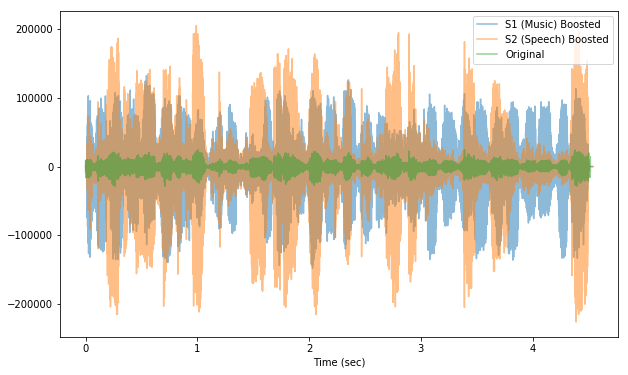

Boosting ratio for S1= 5.620662153181874
Boosting ratio for S2= 5.949204533801516


In [ ]:
plt.plot(np.linspace(0, len(s1)/fs, len(s1)), s1      , alpha=0.5)
plt.plot(np.linspace(0, len(s2)/fs, len(s2)), s2      , alpha=0.5)
plt.plot(np.linspace(0, len(arr[:,0])/fs, len(arr[:,0])), arr[:,0], alpha=0.5)
plt.xlabel('Time (sec)')
plt.legend(['S1 (Music) Boosted', 'S2 (Speech) Boosted', 'Original'])
plt.show()

print('Boosting ratio for S1=',I_theta[idx1]/max(np.mean(np.mean(np.abs(I[0,:,:,:])**2, axis=1), axis=1)**0.5))
print('Boosting ratio for S2=',I_theta[idx2]/max(np.mean(np.mean(np.abs(I[0,:,:,:])**2, axis=1), axis=1)**0.5))